In [1]:
import os

from platform import python_version
import warnings
import time
import datetime as dt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import multiprocessing as mp
import shutil

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.densenet import DenseNet121, preprocess_input, decode_predictions
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.utils import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.initializers import *
from tensorflow.keras import regularizers

import pandas as pd
import numpy as np
import seaborn as sns
from plotly.subplots import make_subplots
import plotly.graph_objects as go

from PIL import Image
import xml.etree.ElementTree as ET
import psutil
import random

warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:
img_size = 96
epochs = 75
batch_size = 48
testsplit = .2
targetx = 96
targety = 96
learning_rate = 0.0001
classes = 7
seed = 23
print(seed)

data_dir = "KDEFMF/Male"
data_dir1= "KDEFMF/Female"

23


In [3]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        brightness_range=[0.9,1.1],
        horizontal_flip=True,
        fill_mode='nearest',
    validation_split=testsplit
)


train_generator = train_datagen.flow_from_directory(
        data_dir,
        target_size=(targetx, targety),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True,
        seed=seed,
       subset="training"
)
train_generator1 = train_datagen.flow_from_directory(
        data_dir1,
        target_size=(targetx, targety),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True,
        seed=seed,
       subset="training"
)
val_generator1 = train_datagen.flow_from_directory(
        data_dir1,
        target_size=(targetx, targety),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False,
        seed=seed,
     subset="validation",
        
)
val_generator = train_datagen.flow_from_directory(
        data_dir,
        target_size=(targetx, targety),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False,
        seed=seed,
     subset="validation",
        
)

Found 1198 images belonging to 7 classes.
Found 1158 images belonging to 7 classes.
Found 286 images belonging to 7 classes.
Found 296 images belonging to 7 classes.


In [4]:
from tensorflow.keras.callbacks import *
checkpoint = ModelCheckpoint('SeqKDEFMalemodel.keras',
                             monitor='val_accuracy',
                             save_best_only=True,
                             verbose=1,
                             mode='auto',
                             save_weights_only=False,
                             save_freq=1)

In [4]:
base_model = DenseNet121(include_top=False, weights='imagenet', input_shape=(targetx, targety, 3))

model = Sequential()

# Custom Layers neccesarry to acheive high acurracy 
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Flatten() (x)
x = BatchNormalization()(x)
x=Dropout(0.3)(x)
x = Dense(512, activation='relu',  kernel_initializer=glorot_uniform(seed),kernel_regularizer=regularizers.L2(0.001),activity_regularizer=regularizers.L2(1e-4), bias_initializer='zeros')(x)
x = BatchNormalization()(x)
x=Dropout(0.3)(x)
x = Dense(256, activation='relu',  kernel_initializer=glorot_uniform(seed),kernel_regularizer=regularizers.L2(0.001),activity_regularizer=regularizers.L2(1e-4), bias_initializer='zeros')(x)
x = BatchNormalization()(x)
x=Dropout(0.3)(x)
x = Dense(128, activation='relu',  kernel_initializer=glorot_uniform(seed),kernel_regularizer=regularizers.L2(0.001),activity_regularizer=regularizers.L2(1e-4), bias_initializer='zeros')(x)
x = BatchNormalization()(x)
x=Dropout(0.3)(x)
predictions = Dense(classes, activation='softmax', kernel_initializer='random_uniform', bias_initializer='zeros')(x)

model = tf.keras.Model(inputs=base_model.input, outputs=predictions)
optimizer = Adam(learning_rate=learning_rate)
loss = "categorical_crossentropy"

for layer in model.layers:
    layer.trainable = True

model.compile(optimizer=optimizer,
              loss=loss,
              metrics=["accuracy"])


In [5]:
# Check data generators
print(f"Number of training samples: {len(train_generator)}")
print(f"Number of validation samples: {len(val_generator)}")

# Check class indices
print(f"Training class indices: {train_generator.class_indices}")
print(f"Validation class indices: {val_generator.class_indices}")

# Check model summary
model.summary()

# Ensure correct optimizer and loss function
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Ensure ModelCheckpoint is correctly configured used for callback to save the best value based on val_accuracy
checkpoint = ModelCheckpoint('SeqKDEFFemalemodel.keras', monitor='val_accuracy', save_best_only=True, verbose=1)

# Train the model with callbacks
history = model.fit(
    train_generator1,
    validation_data=val_generator1,
    epochs=75,
    callbacks=[checkpoint]
)

Number of training samples: 25
Number of validation samples: 7
Training class indices: {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}
Validation class indices: {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 96, 96, 3)         │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ zero_padding2d                │ (None, 102, 102, 3)       │               0 │ input_layer[0][0]          │
│ (ZeroPadding2D)               │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_conv (Conv2D)           │ (None, 48, 48, 64)        │           9,408 │ zero_padding2d[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_bn (BatchNormalization) │ (None, 48, 48, 64)        │             256 │ conv1_conv[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_relu (Activation)       │ (None, 48, 48, 64)        │               0 │ conv1_bn[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ zero_padding2d_1              │ (None, 50, 50, 64)        │               0 │ conv1_relu[0][0]           │
│ (ZeroPadding2D)               │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1 (MaxPooling2D)          │ (None, 24, 24, 64)        │               0 │ zero_padding2d_1[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_0_bn             │ (None, 24, 24, 64)        │             256 │ pool1[0][0]                │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_0_relu           │ (None, 24, 24, 64)        │               0 │ conv2_block1_0_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_conv (Conv2D)  │ (None, 24, 24, 128)       │           8,192 │ conv2_block1_0_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_bn             │ (None, 24, 24, 128)       │             512 │ conv2_block1_1_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_relu           │ (None, 24, 24, 128)       │               0 │ conv2_block1_1_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_conv (Conv2D)  │ (None, 24, 24, 32)        │          36,864 │ conv2_block1_1_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_concat           │ (None, 24, 24, 96)        │               0 │ pool1[0][0],               │
│ (Concatenate)                 │                           │               

 Total params: 7,735,111 (29.51 MB)

 Trainable params: 7,647,623 (29.17 MB)

 Non-trainable params: 87,488 (341.75 KB)

Epoch 1/75
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1820 - loss: 6.1485
Epoch 1: val_accuracy improved from -inf to 0.15035, saving model to SeqKDEFFemalemodel.keras
25/25 ━━━━━━━━━━━━━━━━━━━━ 98s 1s/step - accuracy: 0.1816 - loss: 6.1446 - val_accuracy: 0.1503 - val_loss: 5.8427
Epoch 2/75
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 938ms/step - accuracy: 0.1861 - loss: 5.7130
Epoch 2: val_accuracy improved from 0.15035 to 0.17832, saving model to SeqKDEFFemalemodel.keras
25/25 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.1867 - loss: 5.7187 - val_accuracy: 0.1783 - val_loss: 5.3343
Epoch 3/75
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2283 - loss: 5.6765
Epoch 3: val_accuracy improved from 0.17832 to 0.22028, saving model to SeqKDEFFemalemodel.keras
25/25 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.2293 - loss: 5.6766 - val_accuracy: 0.2203 - val_loss: 5.0386
Epoch 4/75
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2307 - loss: 5.5716
Epoch 4: val_accuracy improved f

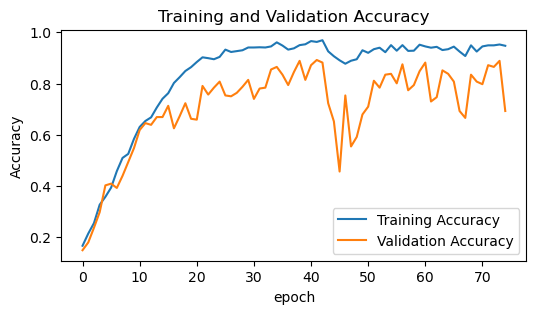

In [7]:
f, ax=plt.subplots(figsize=(6,3))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend()
plt.show()

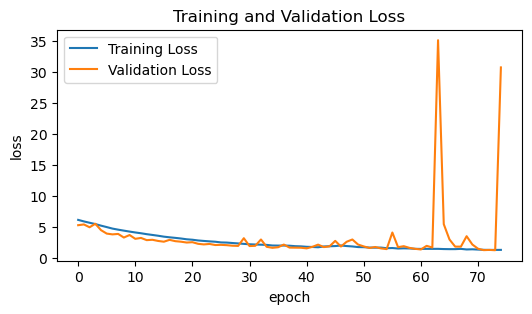

In [8]:
f, ax=plt.subplots(figsize=(6,3))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.show()

7/7 ━━━━━━━━━━━━━━━━━━━━ 31s 3s/step


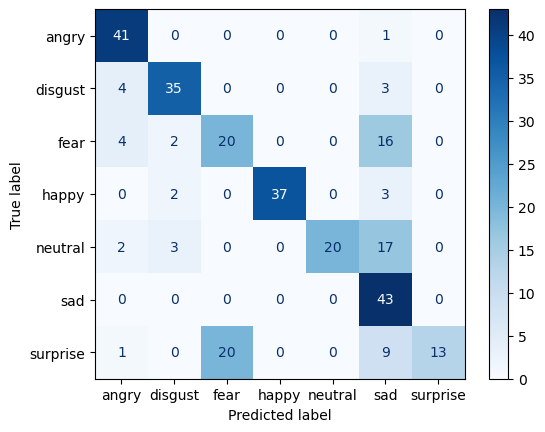

In [9]:
Y_pred = model.predict(val_generator)
y_pred = np.argmax(Y_pred, axis=1)
y_true=val_generator.classes

from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_true,y_pred)
cm

labels=['angry','disgust','fear','happy','neutral','sad','surprise']
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

disp.plot(cmap=plt.cm.Blues)
plt.show()

In [6]:
import tensorflow as tf
model =tf.keras.models.load_model('SeqKDEFFemalemodel.keras')
predictions = model.predict(val_generator, steps=len(val_generator))
y = np.argmax(predictions, axis=1)

print('Classification Report')
cr = classification_report(y_true=val_generator.classes, y_pred=y, target_names=val_generator.class_indices)
print(cr)

7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 795ms/step
Classification Report
              precision    recall  f1-score   support

       angry       0.66      0.90      0.76        42
     disgust       0.86      0.76      0.81        42
        fear       0.42      0.76      0.54        42
       happy       0.97      0.74      0.84        42
     neutral       0.82      0.64      0.72        42
         sad       0.57      0.65      0.61        43
    surprise       1.00      0.23      0.38        43

    accuracy                           0.67       296
   macro avg       0.76      0.67      0.66       296
weighted avg       0.76      0.67      0.66       296



In [7]:
import tensorflow as tf
model =tf.keras.models.load_model('SeqKDEFFemalemodel.keras')
predictions1 = model.predict(val_generator1, steps=len(val_generator1))
y = np.argmax(predictions1, axis=1)

print('Classification Report')
cr = classification_report(y_true=val_generator1.classes, y_pred=y, target_names=val_generator1.class_indices)
print(cr)

6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 884ms/step
Classification Report
              precision    recall  f1-score   support

       angry       0.95      0.98      0.96        41
     disgust       1.00      0.90      0.95        41
        fear       0.74      0.83      0.79        42
       happy       1.00      0.95      0.97        41
     neutral       0.95      1.00      0.98        41
         sad       0.79      0.95      0.86        40
    surprise       1.00      0.75      0.86        40

    accuracy                           0.91       286
   macro avg       0.92      0.91      0.91       286
weighted avg       0.92      0.91      0.91       286



In [8]:
Y_pred = model.predict(val_generator)
y_pred = np.argmax(Y_pred, axis=1)
y_true=val_generator.classes

Y_pred1 = model.predict(val_generator1)
y_pred1 = np.argmax(Y_pred1, axis=1)
y_true1=val_generator1.classes

cm_first = confusion_matrix(y_true, y_pred)

cm_second = confusion_matrix(y_true1, y_pred1)

# Print the confusion matrices
print("Confusion Matrix for First Dataset:")
print(cm_first)

print("Confusion Matrix for Second Dataset:")
print(cm_second)

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 290ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 332ms/step
Confusion Matrix for First Dataset:
[[39  2  0  0  0  1  0]
 [ 6 32  0  0  0  4  0]
 [ 2  1 30  1  2  6  0]
 [ 0  1  9 31  0  1  0]
 [ 7  0  4  0 25  6  0]
 [ 6  3  3  0  1 30  0]
 [ 0  0 27  0  4  2 10]]
Confusion Matrix for Second Dataset:
[[40  0  0  0  1  0  0]
 [ 2 36  1  1  0  1  0]
 [ 1  0 38  0  0  3  0]
 [ 0  0  1 40  0  0  0]
 [ 0  0  0  0 41  0  0]
 [ 1  0  1  0  0 38  0]
 [ 0  0  8  0  1  1 30]]


In [9]:
from keras import metrics

accuracy_male = metrics.Accuracy()
accuracy_female = metrics.Accuracy()
accuracy_male.update_state(y_true, y_pred)
accuracy_female.update_state(y_true1, y_pred1)

# Calculate the accuracy results
accuracy_result_male = accuracy_male.result().numpy()
accuracy_result_female = accuracy_female.result().numpy()

# Print the individual accuracies
print("Male Accuracy: %f" % accuracy_result_male)
print("Female Accuracy: %f" % accuracy_result_female)

# Calculate the accuracy difference
accuracy_difference = accuracy_result_male - accuracy_result_female
DP = accuracy_result_female/accuracy_result_male
# Print the accuracy difference
print("Accuracy Difference: %f" % accuracy_difference)
print("DP: %f" % DP)

Male Accuracy: 0.665541
Female Accuracy: 0.919580
Accuracy Difference: -0.254040
DP: 1.381705


In [22]:
import joblib
# Extract and save TP, FP, TN, FN for the first dataset
metrics_first = {}
for i in range(len(cm_first)):
    TP = cm_first[i, i]
    FP = sum(cm_first[:, i]) - TP
    TN = sum(cm_first[j, j] for j in range(len(cm_first)) if j != i)
    FN = sum(cm_first[i, :]) - TP
    metrics_first[i] = {'TP': TP, 'FP': FP, 'TN': TN, 'FN': FN}

# Extract and save TP, FP, TN, FN for the second dataset
metrics_second = {}
for i in range(len(cm_second)):
    TP = cm_second[i, i]
    FP = sum(cm_second[:, i]) - TP
    TN = sum(cm_second[j, j] for j in range(len(cm_second)) if j != i)
    FN = sum(cm_second[i, :]) - TP
    metrics_second[i] = {'TP': TP, 'FP': FP, 'TN': TN, 'FN': FN}

# Save the metrics to files
joblib.dump(metrics_first, 'female_metrics_first1.joblib')
joblib.dump(metrics_second, 'female_metrics_second1.joblib')

['female_metrics_second1.joblib']

In [23]:
# Load the saved metrics
metrics_first = joblib.load('female_metrics_first1.joblib')
metrics_second = joblib.load('female_metrics_second1.joblib')

# Calculate accuracy for the first dataset
accuracy_first = 0
for class_id in metrics_first.keys():
    TP = metrics_first[class_id]['TP']
    TN = metrics_first[class_id]['TN']
    FP = metrics_first[class_id]['FP']
    FN = metrics_first[class_id]['FN']
    accuracy_first += (TP + TN) / (TP + TN + FP + FN)

accuracy_first /= len(metrics_first)

# Calculate accuracy for the second dataset
accuracy_second = 0
for class_id in metrics_second.keys():
    TP = metrics_second[class_id]['TP']
    TN = metrics_second[class_id]['TN']
    FP = metrics_second[class_id]['FP']
    FN = metrics_second[class_id]['FN']
    accuracy_second += (TP + TN) / (TP + TN + FP + FN)

accuracy_second /= len(metrics_second)

# Calculate the accuracy difference
accuracy_difference = accuracy_first - accuracy_second

# Print the results
print(f"Accuracy for the first dataset: {accuracy_first}")
print(f"Accuracy for the second dataset: {accuracy_second}")
print(f"Accuracy difference: {accuracy_difference}")

Accuracy for the first dataset: 0.45277533573335826
Accuracy for the second dataset: 0.4432819514120327
Accuracy difference: 0.00949338432132557


In [ ]:

# Now you can use the preprocess_image function
original_img, img_array = preprocess_image('32_21.jpg')
prediction = model.predict(img_array)

# Get the index of the highest probability in the prediction
predicted_index = np.argmax(prediction)

# Assuming you have a list of class labels
class_labels = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']  # Example labels

# Map the predicted index to the corresponding label
predicted_label = class_labels[predicted_index]

# Print the predicted label as a string
print(f"Predicted Emotion: {predicted_label}")

# Display the image using matplotlib
plt.imshow(original_img)
plt.title(f"Predicted Emotion: {predicted_label}")
plt.axis('off')  # Turn off the axis
plt.show()  # Display the plot

In [ ]:

# Now you can use the preprocess_image function
original_img, img_array = preprocess_image('PrivateTest_20588149.jpg')
prediction = model.predict(img_array)

# Get the index of the highest probability in the prediction
predicted_index = np.argmax(prediction)

# Assuming you have a list of class labels
class_labels = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']  # Example labels

# Map the predicted index to the corresponding label
predicted_label = class_labels[predicted_index]

# Print the predicted label as a string
print(f"Predicted Emotion: {predicted_label}")

# Display the image using matplotlib
plt.imshow(original_img)
plt.title(f"Predicted Emotion: {predicted_label}")
plt.axis('off')  # Turn off the axis
plt.show()  # Display the plot